#  ATOC5860 Application Lab #4 - fft_mesa - FFT Mesa Data
##### Written by Prof. Kay (CU), with "peer-review" by Dr. Elizabeth Maroon (formerly CU, now U-Wisconsin) Dr. Vineel Yettella (ATOC Ph.D. 2018)
##### last updated March 17, 2023 - works with environment atoc5860env2023clean.yml

<font color='green'> Questions answered by Clairy Reiher (last answered on Thurs, Mar 23, 2022).

### LEARNING GOALS:
1) Complete a spectral analysis using two different functions in Python (direct FFT from numpy and using scipy which has more options). Describe the results including an interpretation of the spectral peaks and an assessment of their statistical significance.
    
<font color='green'> There are 3 main peaks we see in the power spectrum for the temperatures: (1) at a yearly frequency, (2) at a daily frequency (every 24 hours), and (3) at a 12-hourly frequency. All three of these are highly statistically significant.

2) Contrast applying a Boxcar and a Hanning Window when calculating the power spectra. What are the advantages/disadvantages of these two window types?  What are the implications for the resulting power spectra?
    
<font color='green'> The Hanning window causes a given peak to appear wider than when using the Boxcar window, and also reduces the power of the peak (and therefore reduces the estimate of the variance explained by the peak).
    
<font color='green'> The Hanning window seems to be advantageous for its removal of any false "lobes" that might appear on either side of the peak when using the Boxcar window (these lobes appear due to the "response function" that the Boxcar window introduces in the Fourier transform of the discontinuous data). In this case, however, we don't really see these false lobes, so the Hanning window may seem unneccessary, and a Boxcar window may be sufficient for identifying the frequency corresponding to each peak.

3) Compare spectral analysis of common atmospheric variables (temperature, humidity, wind).  Formulate a hypothesis for which variable will have the largest spectral power at diurnal and seasonal frequencies, and test it using spectral analysis.
    
<font color='green'> I would guess temperature to be most directly impacted by the seasonal and diurnal cycles. Therefore, I'd expect the largest spectral power at both frequencies to be found for temperatures.

### DATA and UNDERLYING SCIENCE MOTIVATION:  
In this notebook, you will analyze hourly surface weather observations from Mesa Lab in Boulder Colorado for the years 2016-2021.  Raw data were munged from their original format into a single .csv file for analysis here (see github https://github.com/jenkayco/ATOC5860_Spring2023/tree/main/applicationlabs/lab4/mesadata_process).  Missing data are present in the dataset. The data are in .csv format and are called mesa_data_2016-2021_withmissing.csv.


### Non-exhaustive Questions to guide your analysis:  
**To Start - Execute all code without making any modifications.** 

1) Look at your data.  What are the autocorrelation and e-folding time of your data?  What spectral peaks do you expect to find in your analysis and how much power do you think they will have?
    
<font color='green'> I can clearly see a seasonal (yearly) cycle in the temperatures (so I expect to find to a spectral peak representing this). It's harder to see when looking at the entire time series all at once, but I also expect to find a separate peak representing a diurnal (daily) cycle.
    
<font color='green'> The lag-1 autocorrelation for temperature is 0.99 (extremely high memory). The e-folding time (the time it takes for the autocorrelation to drop to a value of 1/e) is 106 hours (several days).

2) Calculate the power spectra using the Numpy method, which assumes a Boxcar window that is the length of your entire dataset.  Graph the power spectra, the red noise fit to the data, and the 99% confidence interval. What statistically significant spectral peaks did you find?  What do they represent?  How did you assess the statistical significance (what is the null hypothesis that you are trying to reject)?  Compare back to Barnes and Hartman notes to make sure all of the equations and functions in the notebook are working as you expect them too.
    
<font color='green'> There are 3 main peaks we see in the power spectrum for the temperatures: (1) at a yearly frequency, (2) at a daily frequency (every 24 hours), and (3) at a 12-hourly frequency. All three of these are highly statistically significant. We know these peaks are significant because they are above the 99% confidence threshold for being statistically different from the power spectrum for red noise. In other words, the null hypothesis is that the power from our data at a given frequency is not statistically different from the power you would expect in red noise at the same frequency.
    
<font color='green'> The yearly and daily frequencies are representing the seasonal cycle and the diurnal cycle driven by the Earth's revolution around the Sun and it's rotation on its axis. Not a clue what the 12-hourly frequency could be representing though.

3) Calculate the power spectra using the scipy method.  Check that you get the same result as you got using the Numpy method.  Next – compare the power spectra obtained using both a Boxcar window and a Hanning window.   Assume a window length that is the entire length of the dataset. Do you get the same statistically significant peaks when applying the Hanning window and the Boxcar window?  How do they differ? Can you explain why?
    
<font color='green'> The peaks obtained using the Boxcar and Hanning windows are both highly statistically significant. The Hanning window causes a given peak to appear wider than when using the Boxcar window, and also reduces the power of the peak (and therefore reduces the estimate of the variance explained by the peak). This makes sense, given the differences in the resulting response function (or "weighting" function) that results from the Hanning window vs. the Boxcar window. The Hanning window is meant to apply some smoothing across the peak, it removes any false "lobes" that might appear on either side of the peak when using the Boxcar window.

4) If time – take a look at other surface meteorological variables in the dataset.  Do you obtain similar spectral peaks?
    
<font color='green'> RH features peaks at the same frequencies, although the yearly peak occurs with a very low power compared to the temperature power spectrum. The same thing happens with the yearly peak in wind speeds. Additionally, there are three peaks occurring around a frequency of 12 hours in wind speeds as opposed to a single peak at 12 hours. Pressure shows no peak at a daily frequency, but shows clear, statistically significant peaks at yearly and 12-hourly frequencies.

Random Question: Are you seeing power at 12-hour frequencies when looking at temperature?  Maybe it is atmospheric tides? Or is it some kind of spectral ringing artifact?  Unsolved mysteries of ATOC5860 Objective Data Analysis…

<font color='green'> It's honestly hilarious to me that we see a statistically significant peak at 12 hours in temperature. I keep thinking about it and literally cannot even fathom what that could be. All I can do is laugh.

In [1]:
#import modules
import numpy as np   #for calculations
import matplotlib.pyplot as plt  #for plotting
import pandas as pd  #for reading in data
import datetime    #for manipulation by dtae
import collections  #for additional dictionary functionality
from matplotlib.gridspec import GridSpec #for subplots
import scipy.signal as signal #for signal processing
import scipy.stats as stats

In [2]:
def create_normalized_redfit(data_length,Te):
    freq = np.arange(0,(data_length/2)+1,1)/float(data_length) # to Nyquist
    red_fit = (2 * Te)/(1 + ((2*np.pi*freq)**2)*(Te**2)) # After Hartmann 6.64, 6.91
    return red_fit/np.sum(red_fit)
def create_f_bounds(alpha,dof,red_fit_n):
    f_ratio = stats.f.ppf(alpha,dof,200) # Note: 200 = large degree of freedom for red noise
    return f_ratio*red_fit_n

In [3]:
## Read in the data
filename = 'mesa_data_2016-2021_withmissing.csv'
data_all=pd.read_csv(filename,sep=',')
data_all.head()

,day,hour_UTC,pres_mb,tdry_degC,rh_percent,wdir,wspd_m_per_s,wspdmax_m_per_s,raina_event_mm,year
0,2016-01-01,0.0,817.400024,-7.7,72.099998,316.0,2.2,3.0,0.0,2016
1,2016-01-01,1.0,817.599976,-8.1,74.699997,327.0,0.9,1.3,0.0,2016
2,2016-01-01,2.0,818.099976,-8.0,70.500000,227.0,1.7,2.8,0.0,2016
3,2016-01-01,3.0,818.500000,-8.1,69.599998,220.0,1.6,2.9,0.0,2016
4,2016-01-01,4.0,818.799988,-10.0,70.900002,336.0,0.9,2.2,0.0,2016


In [4]:
included_cols = ['pres_mb','tdry_degC','rh_percent','wdir','wspd_m_per_s','wspdmax_m_per_s','raina_event_mm'] 

## Convert to a numpy array for model input
## Leave out the time dimensions (day and hour), and wind directions
data = data_all.loc[:, data_all.columns.isin(list(included_cols))].to_numpy()

## Copy the data array into a new array without missing values (called data_nomissing)
data_nomissing=data.copy();
print('Shape of data_nomissing: '+format(data_nomissing.shape))

option_missing='option1'

## One option is to replace the NaN data with the mean value over the entire dataset, which is employed here
if option_missing=='option1':
    data_nomissing[:,0]=np.where(np.isnan(data[:,0])==True,np.nanmean(data[:,0]),data[:,0])
    data_nomissing[:,1]=np.where(np.isnan(data[:,1])==True,np.nanmean(data[:,1]),data[:,1])
    data_nomissing[:,2]=np.where(np.isnan(data[:,2])==True,np.nanmean(data[:,2]),data[:,2])
    data_nomissing[:,3]=np.where(np.isnan(data[:,3])==True,np.nanmean(data[:,3]),data[:,3])
    data_nomissing[:,4]=np.where(np.isnan(data[:,4])==True,np.nanmean(data[:,4]),data[:,4])
    data_nomissing[:,5]=np.where(np.isnan(data[:,5])==True,np.nanmean(data[:,5]),data[:,5])
    data_nomissing[:,6]=np.where(np.isnan(data[:,6])==True,np.nanmean(data[:,6]),data[:,6])

### other options one could use here... how would you deal with missing data here?

Shape of data_nomissing: (52560, 7)


In [39]:
## Calculate the temperature anomaly and set that equal to the variable "data"
foo = data_nomissing[:,1]
data = foo-np.mean(foo)
var_str = "Temperature" 
data_units = "C"

### other variables to try (uncomment the code)
#foo=data_nomissing[:,2]
#data=foo-np.mean(foo)
#var_str = "RelativeHumidity"
#data_units = "%"

#foo=data_nomissing[:,4]
#data=foo-np.mean(foo)
#var_str = "Wind"
#data_units = "mph"

In [40]:
## Calculate lag-1 autocorrelation and e-folding time of data
## The e-folding time scale for the autocorrelation function is the lag time at which the autocorrelation
## value (rho) drops to 1/e (which is approximately 0.37)
rho,lag1_p = stats.pearsonr(data[0:len(data)-1],data[1:len(data)]) # rho = lag1_r
Te = -1./np.log(rho) # After Hartmann 6.4 with delta t = 1
print(var_str,'lag-1 autocorrelation =',round(rho,2),'and Te =',round(Te,2),'hours')

Temperature lag-1 autocorrelation = 0.99 and Te = 106.94 hours


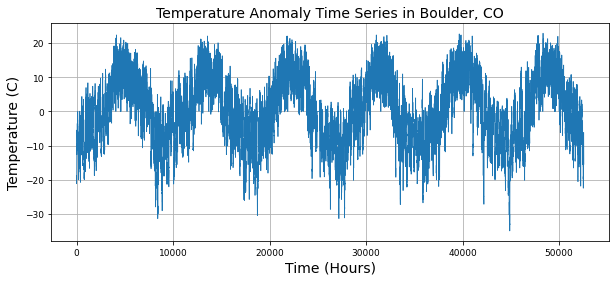

In [41]:
## Plot the entire time series
fig = plt.figure(figsize=(10,4))
plt.plot(data, lw=.75)
plt.ylabel(var_str+" ("+data_units+")",fontsize=14)
plt.xlabel('Time (Hours)',fontsize=14)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.title(var_str+" Anomaly Time Series in Boulder, CO",fontsize=14)
plt.grid()
#plt.savefig('XX.pdf', dpi=300, format='png')

In [42]:
alpha = 0.99 ## set statistical significance level

##### METHOD #1 - Calculate the FFT of the temperatures using numpy

#Compute the amplitude of the Fourier transform (the power, or y-axis of the power spectrum that gets outputted
#by the Fourier transform)
A = np.fft.rfft(data)
#Find the frequencies across which the Fourier transform is computed (the x-axis of the power spectrum)
freq = np.fft.rfftfreq(len(data),d=1.0)

#Convert the amplitude of the Fourier transform to power
#This power gives the actual variance explained by each frequency
ps = (np.abs(A)**2)/2.0
#Normalize the amplitude of the Fourier transform
#This gives the percentage of variance explaiend by each frequency
ps_n = ((np.abs(A)**2)/2.0)/(np.sum(np.abs(A)**2)/2.0)
Ao = ps[0]

#Compute a red noise power spectrum with the same length as the temperature data
red_fit_n = create_normalized_redfit(len(data),Te)
#Find the 99% confidence interval bounds on the F statistic comparing the power spectrum for the
#temperature data to the power spectrum for red noise data
f_bounds = create_f_bounds(alpha,2*1,red_fit_n)
#Also find the 99% confidence interval bounds on the F statistic when a Hanning smoothing is applied
#We're just multiplying the degrees of freedom by 1.2 due to extra Hanning smoothing
#Degrees of freedom computation comes from Barnes Chap 4 Equation 26
f_bounds_hanning = create_f_bounds(alpha,2*1*1.2,red_fit_n)

In [43]:
#Find the significant spectral peaks
for i in range(len(ps_n)):
    if (ps_n[i] - f_bounds[i]) > 1e-03:  
        #Question: why 1e-03?  This choice trying to select peaks that are well above 99% threshold.
        print('##### FOUND IT - spectral peak exceeds red noise ####')
        print('exceeds by...',ps_n[i]-f_bounds[i])
        print('at frequency....',freq[i])
        print('which in units of days is...',(1/freq[i])/24.)
        
## for reference -- what is 12-hourly, daily, and yearly frequencies in frequency units?
print('\nXXXX FOR REFERENCE XXXX')
print('12-hourly in frequency:',round(1/12,3))
print('24-hourly/daily in frequency:',round(1/24,3))
print('yearly in frequency:',round(1/(24*365),5))  

##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.5433137086258507
at frequency.... 0.00011415525114155252
which in units of days is... 365.0
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.0338414208544037
at frequency.... 0.04166666666666667
which in units of days is... 0.9999999999999999
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.0016510217913104676
at frequency.... 0.08333333333333334
which in units of days is... 0.49999999999999994

XXXX FOR REFERENCE XXXX
12-hourly in frequency: 0.083
24-hourly/daily in frequency: 0.042
yearly in frequency: 0.00011


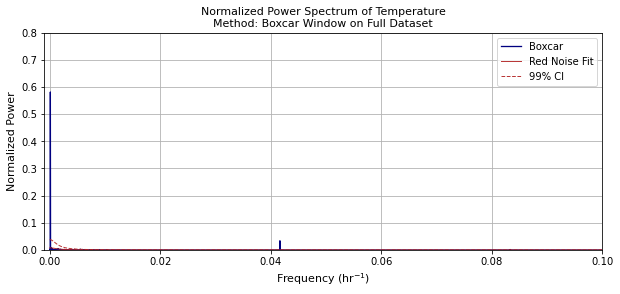

In [44]:
### Plot the results
fig = plt.figure(figsize=(10,4))
method_str = "Method: Boxcar Window on Full Dataset"
plt.plot(freq,ps_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit') # freq plots 0...0.5
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.80)
plt.xlim(-0.001,0.1)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=11)
plt.ylabel("Normalized Power",fontsize=11)
plt.title("Normalized Power Spectrum of "+var_str+"\n"+method_str,fontsize=11)
plt.legend(loc='upper right',fontsize=10)
plt.grid()

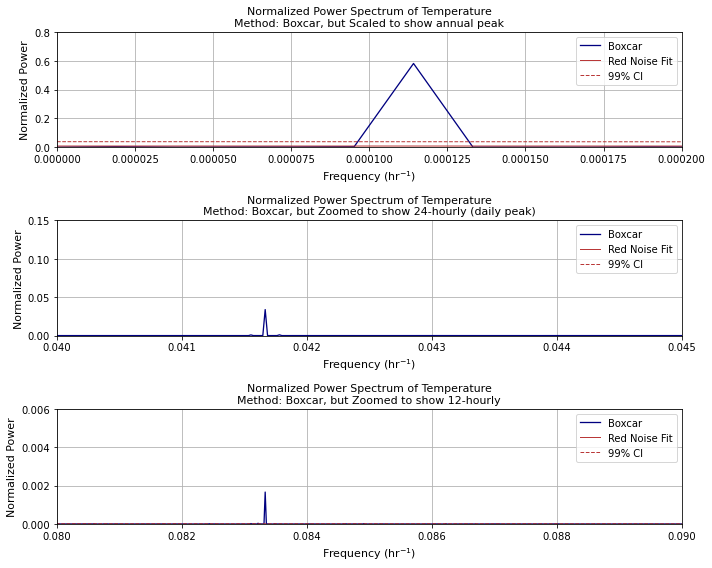

In [45]:
### Plot the results -- zoom in to get a better look at the three large peaks

## Plotting to highlight peak for yearly frequency
fig = plt.figure(figsize=(10,8))
gs=GridSpec(3,1)
ax=plt.subplot(gs[0,0])
method_str = "Method: Boxcar, but Scaled to show annual peak"
plt.plot(freq,ps_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit') # freq plots 0...0.5
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.8)
plt.xlim(0.0,0.0002)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=11)
plt.ylabel("Normalized Power",fontsize=11)
plt.title("Normalized Power Spectrum of "+var_str+"\n"+method_str,fontsize=11)
plt.legend(loc='upper right',fontsize=10)
plt.grid()

## Plotting to highlight peak for daily frequency 
ax=plt.subplot(gs[1,0])
method_str = "Method: Boxcar, but Zoomed to show 24-hourly (daily peak)"
plt.plot(freq,ps_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit') # freq plots 0...0.5
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.15)
plt.xlim(0.04,0.045)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=11)
plt.ylabel("Normalized Power",fontsize=11)
plt.title("Normalized Power Spectrum of "+var_str+"\n"+method_str,fontsize=11)
plt.legend(loc='upper right',fontsize=10)
plt.grid()

## Plotting highlight peak for 12-hourly frequency
ax=plt.subplot(gs[2,0])
method_str = "Method: Boxcar, but Zoomed to show 12-hourly"
plt.plot(freq,ps_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit') # freq plots 0...0.5
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.006)
plt.xlim(0.08,0.09)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=11)
plt.ylabel("Normalized Power",fontsize=11)
plt.title("Normalized Power Spectrum of "+var_str+"\n"+method_str,fontsize=11)
plt.legend(loc='upper right',fontsize=10)
plt.grid()
fig.tight_layout()

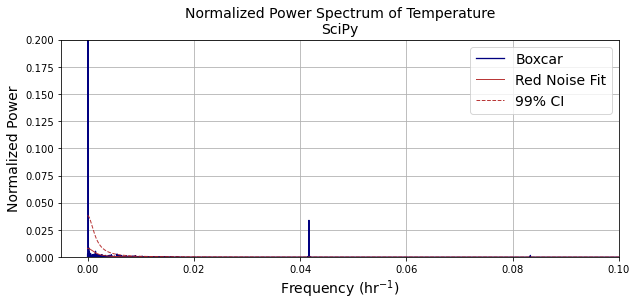

In [46]:
##### METHOD #2 - uses a different python function and library to do the same thing, not a different method mathematically.
## Calculate the power specra using the scipy method... let's see if we get the same answer - we should :).
## http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html#scipy.signal.periodogram
f,Pxx = signal.periodogram(data,fs=1.,window='boxcar',nfft=None,return_onesided=True,scaling='spectrum')
Pxx_n = Pxx/np.sum(Pxx)

method_str = "SciPy"
fig = plt.figure(figsize=(10,4))
plt.plot(f,Pxx_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.2)
plt.xlim(-0.005,0.1)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=14)
plt.ylabel("Normalized Power",fontsize=14)
plt.title("Normalized Power Spectrum of "+var_str+"\n"+method_str,fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()

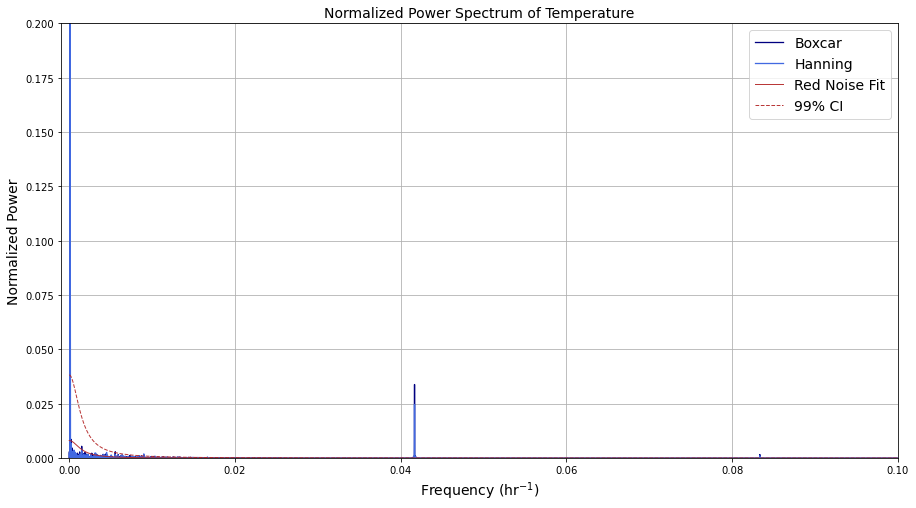

In [47]:
## Note: The benefit of the scipy function is that it has more options so we can for example
## compare results using a Boxcar and Hanning Window.
## You should see a broader peak with the tapered Hanning Window than with the square Boxcar window.
## Can you explain why?  (refer back to lecture #10 of ATOC7500)
## Which window would you prefer??  (Jen prefers the Boxcar for its spectral accuracy... do you agree with her?)
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html#scipy.signal.periodogram

f,Pxx = signal.periodogram(data,fs=1.0,window='boxcar',nfft=None,return_onesided=True,scaling='spectrum')
Pxx_n = Pxx/np.sum(Pxx)
f_h,Pxx_h = signal.periodogram(data,fs=1.0,window='hamming',nfft=None,return_onesided=True,scaling='spectrum')
Pxx_h_n = Pxx_h/np.sum(Pxx_h)

fig = plt.figure(figsize=(15,8))
plt.plot(f,Pxx_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(f_h,Pxx_h_n, color='royalblue', lw=1.3, label='Hanning')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.2)
plt.xlim(-0.001,0.1)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=14)
plt.ylabel("Normalized Power",fontsize=14)
plt.title("Normalized Power Spectrum of "+var_str,fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()

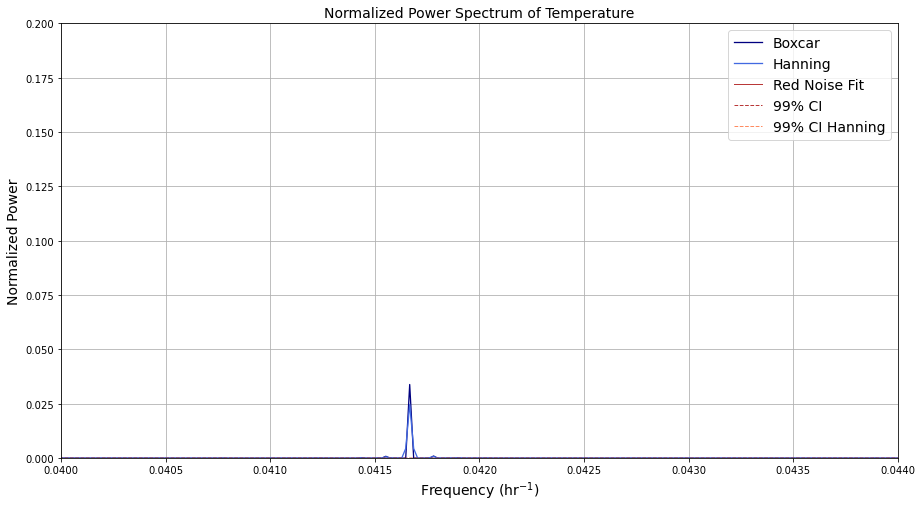

In [48]:
### You need to zoom in to see the extra smoothing caused by the Hanning Window.
fig = plt.figure(figsize=(15,8))
plt.plot(f,Pxx_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(f_h,Pxx_h_n, color='royalblue', lw=1.3, label='Hanning')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.plot(freq,f_bounds_hanning, color='coral', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI Hanning')

plt.ylim(0.0,0.20)
plt.xlim(0.04,0.044)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=14)
plt.ylabel("Normalized Power",fontsize=14)
plt.title("Normalized Power Spectrum of "+var_str,fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()

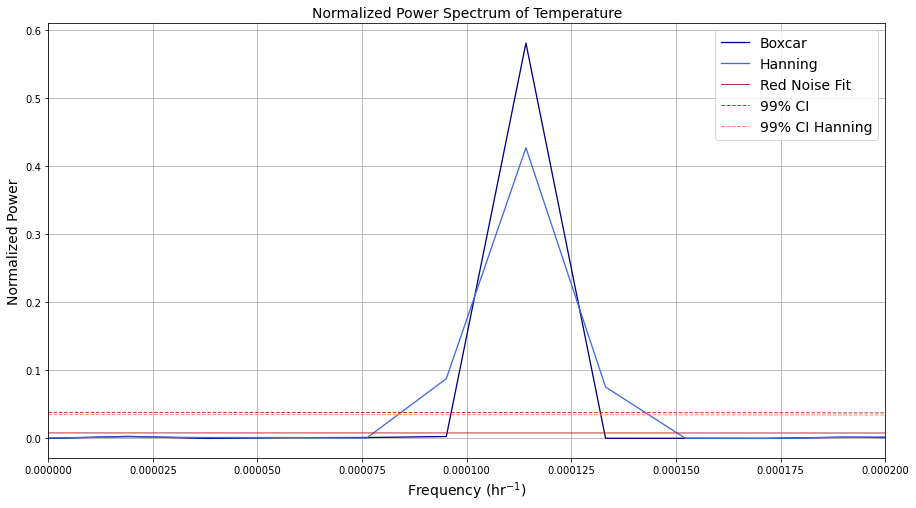

In [49]:
### You need to zoom in to see the extra smoothing caused by the Hanning Window.
### ##### FOUND IT - spectral peak exceeds red noise ####
##exceeds by... 0.04849019553988333
##at frequency.... 0.00011415525114155251
##which in days is... 365.0

fig = plt.figure(figsize=(15,8))
plt.plot(f,Pxx_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(f_h,Pxx_h_n, color='royalblue', lw=1.3, label='Hanning')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.plot(freq,f_bounds_hanning, color='coral', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI Hanning')
#plt.ylim(0.0,0.40)
plt.xlim(0.00,0.0002)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=14)
plt.ylabel("Normalized Power",fontsize=14)
plt.title("Normalized Power Spectrum of "+var_str,fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()